# CIFAR10 classification with EfficientNetV2B2 from scratch ( not using ImageNet weights)
* **TPU Distributed Training with Keras-3 and jax as its backend**

In [1]:
!pip install -q tensorflow-cpu
!pip install --upgrade -q keras


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# if you face OOM, uncomment this line bellow
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

## Setting Keras DataParallel strategy for distributed training

In [3]:


import keras

devices = keras.distribution.list_devices()
print(devices)
data_parallel = keras.distribution.DataParallel(devices=devices)

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
mesh_1d = keras.distribution.DeviceMesh(
    shape=(8, ), axis_names=["data"], devices=devices
)
data_parallel = keras.distribution.DataParallel(device_mesh=mesh_1d)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

E0000 00:00:1738410304.797983     993 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']


In [6]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetV2B2

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32 * len(devices)

## Mixed Precision Computation for lower memory usage and higher training speed

In [7]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

## Reproduction

In [8]:
keras.utils.set_random_seed(0)

## Downloading dataset

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
NUM_CLASSES = 10
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [10]:
y_train.shape

(50000, 10)

In [12]:
import tensorflow as tf

# Create TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [13]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

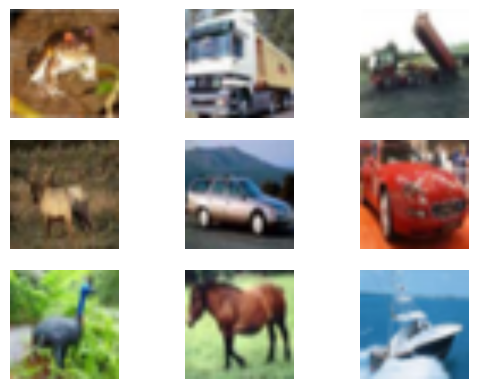

In [14]:



for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

    plt.axis("off")

In [15]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

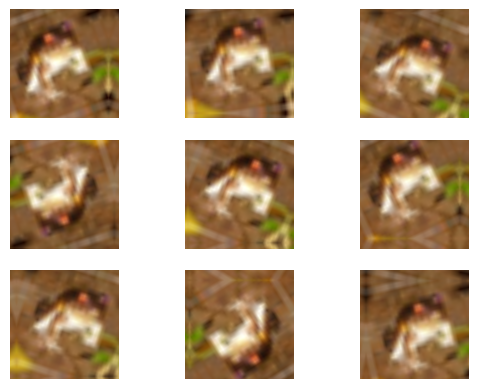

In [16]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.axis("off")

## Data Augmentation

In [17]:


# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [19]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

def get_model():
    model = EfficientNetV2B2(
    include_top=False,
    weights=None, # Training from scratch
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = True


    classifier = Sequential([
                             model,
                             GlobalAveragePooling2D(),
                             Dropout(0.1),
                             Dense(NUM_CLASSES, activation = 'softmax')])
    
    
    return classifier

In [20]:

model = get_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetv2-b2           │ (None, 7, 7, 1408)    │  8,769,374 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1408)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1408)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 10)            │     14,090 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 8,783,464 (33.51 MB)

 Trainable params: 8,701,176 (33.19 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Training the model

In [22]:
history = model.fit(ds_train, validation_data = ds_test, epochs = 100)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 129s 243ms/step - accuracy: 0.2245 - loss: 2.1253 - val_accuracy: 0.3642 - val_loss: 1.7574
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.3100 - loss: 1.9254 - val_accuracy: 0.4285 - val_loss: 1.5474
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.4085 - loss: 1.6251 - val_accuracy: 0.5112 - val_loss: 1.3471
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.4698 - loss: 1.4733 - val_accuracy: 0.5438 - val_loss: 1.2615
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.5122 - loss: 1.3536 - val_accuracy: 0.5898 - val_loss: 1.1436
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.5540 - loss: 1.2480 - val_accuracy: 0.6213 - val_loss: 1.0670
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.5871 - loss: 1.1579 - val_accuracy: 0.6640 - val_loss: 0.9619
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.6216 

## Plotting model results

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


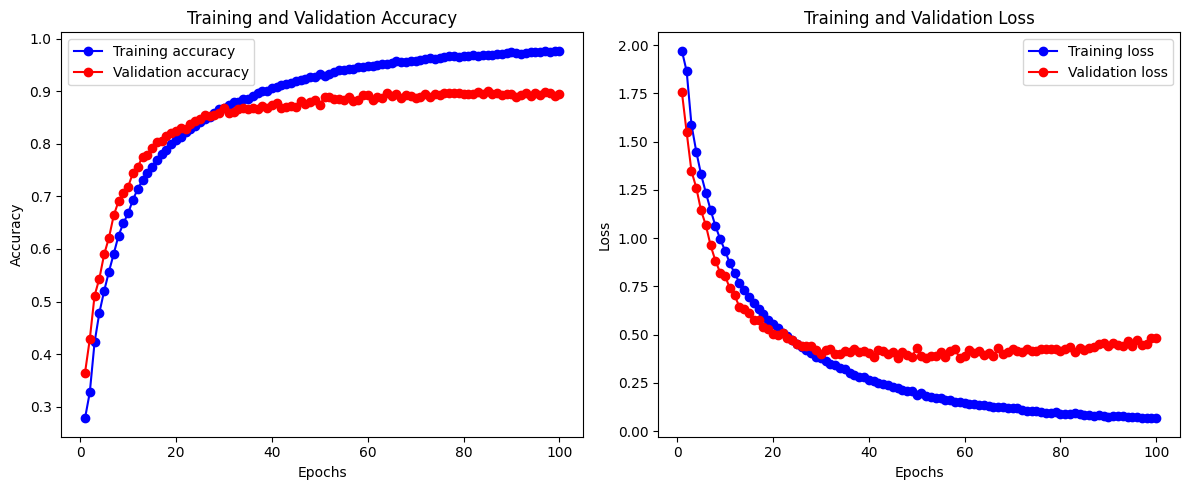

In [23]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
accuracy = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    has_validation = True
else:
    has_validation = False

# Create epochs range
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
if has_validation:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
if has_validation:
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()